In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov5nu.pt')  # load an official model

# Predict with the model
results = model(r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019\camera_front\000001.jpg")  # predict on an image
import torch
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
import json

# Define paths
data_dir = Path(r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019")
images_dir = data_dir / (r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019\camera_front")
labels_dir = data_dir / (r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019\groundtruth_obj3d")
# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Create a directory to save the bounding box coordinates
output_dir = data_dir / "vehicle_coordinates"
output_dir.mkdir(exist_ok=True)

# Process each image in the dataset
for image_path in tqdm(list(images_dir.glob("*.jpg"))):
    # Perform inference
    results = model(image_path)
    
    # Extract bounding box coordinates for vehicles
    bboxes = results.xyxy[0].cpu().numpy()  # Get bounding boxes in (x_min, y_min, x_max, y_max, confidence) format
    vehicle_bboxes = bboxes[np.isin(bboxes[:, 5], [2, 5, 7])]
  # Assuming class 2 corresponds to vehicles
    
    # Save bounding box coordinates
    image_name = image_path.stem
    np.savetxt(output_dir / f"{image_name}_vehicle_coordinates.txt", vehicle_bboxes[:, :4], fmt='%d')
    
    # Optionally, visualize the detection results
    img = cv2.imread(str(image_path))
    for bbox in vehicle_bboxes:
        xmin, ymin, xmax, ymax = bbox[:4].astype(int)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.imwrite(str(output_dir / f"{image_name}_vehicle_detection.jpg"), img)


image 1/1 D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019\camera_front\000001.jpg: 224x640 23 cars, 190.9ms
Speed: 4.1ms preprocess, 190.9ms inference, 3.3ms postprocess per image at shape (1, 3, 224, 640)


Using cache found in C:\Users\sanva/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-1-2 Python-3.13.0 torch-2.6.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\sanva/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\sanva/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\sanva/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\sanva/.cache\torch\hub\ultralytics_yolov5_mas

Image shape: (618, 2048, 3)
LiDAR shape: (17342, 6) Radar shape: (1104, 5)


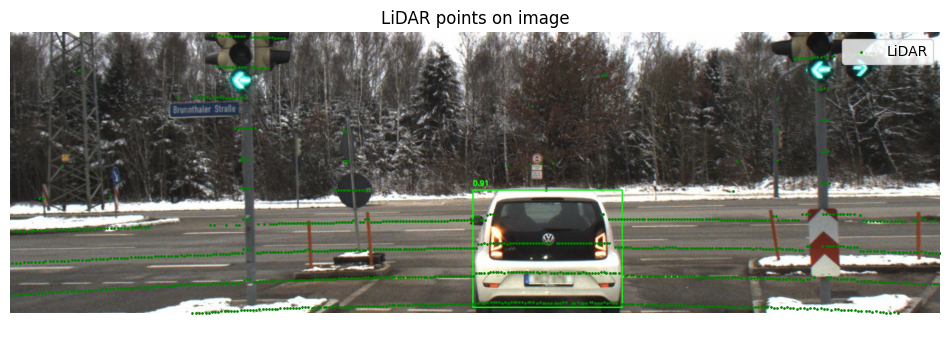

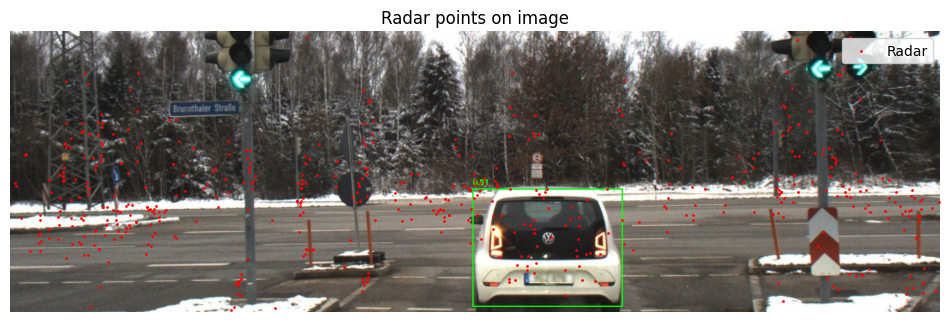

In [3]:
%matplotlib inline
import json, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

class calib_astyx:
    def __init__(self, file):
        data = json.load(open(file))
        self.radar2ref = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K = np.array(data["sensors"][2]["calib_data"]["K"])
        self.ref2radar  = self.inv_trans(self.radar2ref)
        self.ref2lidar  = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)
    @staticmethod
    def inv_trans(T):
        R = np.linalg.inv(T[:3,:3]); t = -R @ T[:3,3]
        return np.hstack([R, t.reshape(3,1)])
    def lidar2ref(self, pts):
        n = pts.shape[0]
        hom = np.hstack([pts, np.ones((n,1))])
        out = hom @ self.lidar2ref_cos.T
        return out[:,:3]
    def ref2Camera(self, pts, img_size):
        P = self.ref2camera
        XYZ = (P[:3,:3] @ pts.T) + P[:3,3:4]
        uvw = self.K @ XYZ
        uv = (uvw / uvw[2])[:2]
        W, H = img_size
        mask = (uv[0] >= 0) & (uv[0] < W) & (uv[1] >= 0) & (uv[1] < H) & (pts[:,0] >= 0)
        return uv[:,mask], mask

root = r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019"
i = 85
img_path   = Path(root) / "vehicle_coordinates" / f"{i:06d}_vehicle_detection.jpg"
lidar_path = Path(root) / "lidar_vlp16"         / f"{i:06d}.txt"
radar_path = Path(root) / "radar_6455"          / f"{i:06d}.txt"
calib_path = Path(root) / "calibration"         / f"{i:06d}.json"

# Hard checks (print helpful hints if anything is missing)
for p in [img_path, lidar_path, radar_path, calib_path]:
    if not p.exists(): raise FileNotFoundError(f"Missing: {p}")

img = cv2.imread(str(img_path))
if img is None: raise ValueError(f"cv2.imread failed for: {img_path}")
print("Image shape:", img.shape)

lidar = np.loadtxt(str(lidar_path), skiprows=1)
radar = np.loadtxt(str(radar_path), skiprows=2)
print("LiDAR shape:", lidar.shape, "Radar shape:", radar.shape)

calib = calib_astyx(str(calib_path))

lidar_xyz = calib.lidar2ref(lidar[:, :3])
lidar_uv, lidar_mask = calib.ref2Camera(lidar_xyz, (img.shape[1], img.shape[0]))
radar_uv, radar_mask = calib.ref2Camera(radar[:, :3], (img.shape[1], img.shape[0]))

# LiDAR overlay
plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
if lidar_uv.size:
    plt.scatter(lidar_uv[0], lidar_uv[1], s=1, c='green' ,alpha=0.9, label="LiDAR")
plt.legend(loc="upper right"); plt.axis("off"); plt.title("LiDAR points on image")
plt.show()

# Radar overlay
plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
if radar_uv.size:
    plt.scatter(radar_uv[0], radar_uv[1], s=1, c='red' ,alpha=0.9, label="Radar")
plt.legend(loc="upper right"); plt.axis("off"); plt.title("Radar points on image")
plt.show()


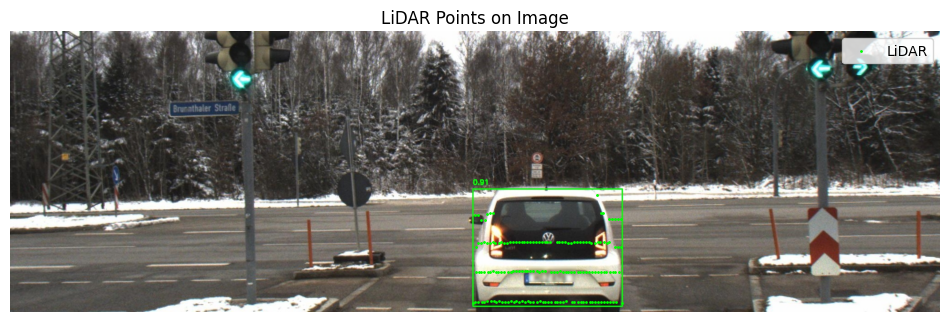

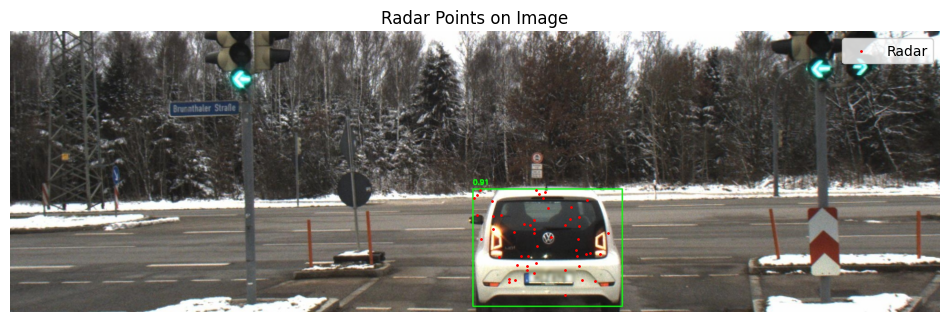

In [8]:
%matplotlib inline
import json, cv2, numpy as np
import matplotlib.pyplot as plt

class calib_astyx:
    def __init__(self, file):
        with open(file) as f:
            d = json.load(f)
        self.radar2ref     = np.array(d["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref_cos = np.array(d["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref    = np.array(d["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K             = np.array(d["sensors"][2]["calib_data"]["K"])
        self.ref2radar  = self.inv_trans(self.radar2ref)
        self.ref2lidar  = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        R = np.linalg.inv(T[:3,:3]); t = -R @ T[:3,3]
        return np.hstack([R, t.reshape(3,1)])

    def lidar2ref(self, pts):
        n = pts.shape[0]
        hom = np.hstack([pts, np.ones((n,1))])
        out = hom @ self.lidar2ref_cos.T
        return out[:,:3]

    def ref2Camera(self, pts, img_size, bbox):
        XYZ = (self.ref2camera[:3,:3] @ pts.T) + self.ref2camera[:3,3:4]
        uvw = self.K @ XYZ
        uv  = (uvw / uvw[2])[:2]
        W, H = img_size
        mask = (uv[0] >= 0) & (uv[0] < W) & (uv[1] >= 0) & (uv[1] < H) & \
               (uv[0] >= bbox[0]) & (uv[0] <= bbox[2]) & \
               (uv[1] >= bbox[1]) & (uv[1] <= bbox[3])
        return uv[:, mask], mask

root = r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019"
i = 85
img = cv2.imread(f"{root}/vehicle_coordinates/{i:06d}_vehicle_detection.jpg")
lidar = np.loadtxt(f"{root}/lidar_vlp16/{i:06d}.txt", skiprows=1)
radar = np.loadtxt(f"{root}/radar_6455/{i:06d}.txt",   skiprows=2)
calib = calib_astyx(f"{root}/calibration/{i:06d}.json")

lidar[:, :3] = calib.lidar2ref(lidar[:, :3])
bbox = (1019, 347, 1348, 605)  # (x1, y1, x2, y2)

lidar_uv, lidar_mask = calib.ref2Camera(lidar[:, :3], (img.shape[1], img.shape[0]), bbox)
radar_uv, radar_mask = calib.ref2Camera(radar[:, :3], (img.shape[1], img.shape[0]), bbox)

plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
if lidar_uv.size:
    plt.scatter(lidar_uv[0], lidar_uv[1], c='lime', s=1, label='LiDAR')
plt.title("LiDAR Points on Image"); plt.axis("off"); plt.legend(loc="upper right"); plt.show()

plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
if radar_uv.size:
    plt.scatter(radar_uv[0], radar_uv[1], c='red', s=1, label='Radar')
plt.title("Radar Points on Image"); plt.axis("off"); plt.legend(loc="upper right"); plt.show()


Mean distances (LiDAR): [np.float64(10.245140815692334)]
Mean distances (Radar): [np.float64(15.670901844266183)]


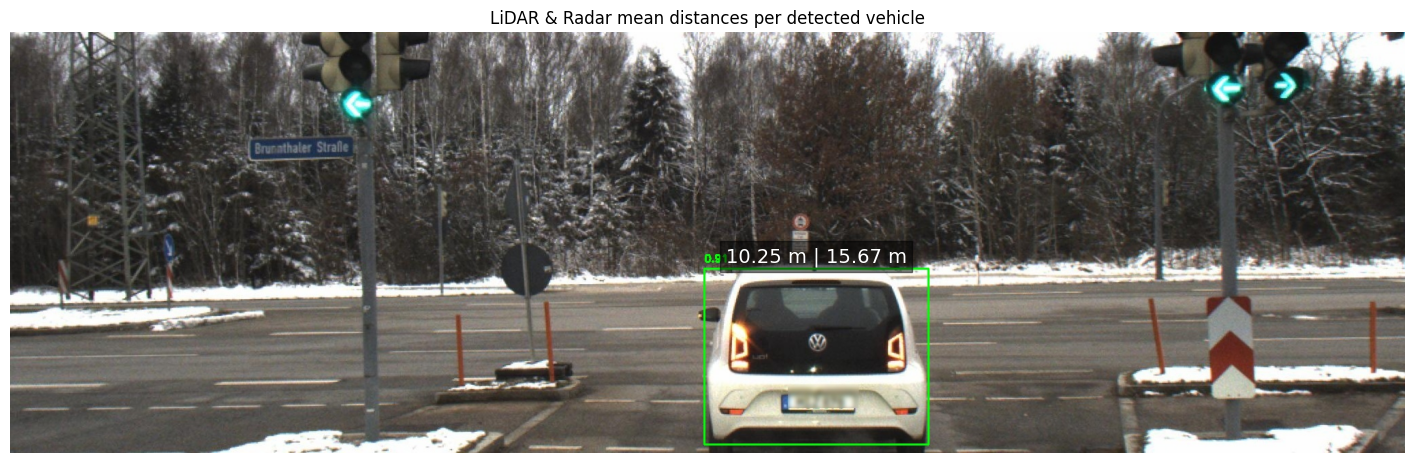

In [9]:
%matplotlib inline
import json, cv2, numpy as np, matplotlib.pyplot as plt

class calib_astyx:
    def __init__(self, file):
        with open(file) as f:
            data = json.load(f)
        self.radar2ref     = np.array(data["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref_cos = np.array(data["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref    = np.array(data["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K             = np.array(data["sensors"][2]["calib_data"]["K"])
        self.ref2radar  = self.inv_trans(self.radar2ref)
        self.ref2lidar  = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        R = np.linalg.inv(T[:3,:3]); t = -R @ T[:3,3]
        return np.hstack([R, t.reshape(3,1)])

    def lidar2ref(self, pts):
        n = pts.shape[0]
        hom = np.hstack([pts, np.ones((n,1))])
        out = hom @ self.lidar2ref_cos.T
        return out[:,:3]

    def ref2Camera(self, pts, img_size, bbox_list):
        obj_image_list, mask_list = [], []
        for bbox in bbox_list:
            XYZ = (self.ref2camera[:3,:3] @ pts.T) + self.ref2camera[:3,3:4]
            uvw = self.K @ XYZ
            uv = (uvw / uvw[2])[:2]
            W, H = img_size
            mask = (uv[0]>=0)&(uv[0]<W)&(uv[1]>=0)&(uv[1]<H)& \
                   (uv[0]>=bbox[0])&(uv[0]<=bbox[2])& \
                   (uv[1]>=bbox[1])&(uv[1]<=bbox[3])
            obj_image_list.append(uv[:,mask]); mask_list.append(mask)
        return obj_image_list, mask_list

    def mean_distance(self, pts, mask):
        cam_pts = (self.ref2camera[:3,:3] @ pts) + self.ref2camera[:3,3:4]
        dist = np.linalg.norm(cam_pts, axis=0)
        return np.mean(dist)

root = r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019"
i = 85
img   = cv2.imread(f"{root}/vehicle_coordinates/{i:06d}_vehicle_detection.jpg")
lidar = np.loadtxt(f"{root}/lidar_vlp16/{i:06d}.txt", skiprows=1)
radar = np.loadtxt(f"{root}/radar_6455/{i:06d}.txt", skiprows=2)
calib = calib_astyx(f"{root}/calibration/{i:06d}.json")

# load bounding boxes
bbox_file = f"{root}/vehicle_coordinates/{i:06d}_vehicle_coordinates.txt"
bboxes = [tuple(map(int, line.strip().split())) for line in open(bbox_file)]

# transform + project
lidar[:, :3] = calib.lidar2ref(lidar[:, :3])
lidar_uv, lidar_mask = calib.ref2Camera(lidar[:, :3], (img.shape[1], img.shape[0]), bboxes)
radar_uv, radar_mask = calib.ref2Camera(radar[:, :3], (img.shape[1], img.shape[0]), bboxes)

# distances per bbox
lidar_mean = [calib.mean_distance(lidar[mask,:3].T, None) for mask in lidar_mask]
radar_mean = [calib.mean_distance(radar[mask,:3].T, None) for mask in radar_mask]

print("Mean distances (LiDAR):", lidar_mean)
print("Mean distances (Radar):", radar_mean)

# display
plt.figure(figsize=(18,12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for bbox, ld, rd in zip(bboxes, lidar_mean, radar_mean):
    cx, cy = (bbox[0]+bbox[2])//2, bbox[1]-10
    plt.text(cx, cy, f"{ld:.2f} m | {rd:.2f} m", color="white",
             fontsize=14, ha="center", bbox=dict(facecolor="black", alpha=0.5))
plt.axis("off")
plt.title("LiDAR & Radar mean distances per detected vehicle")
plt.show()




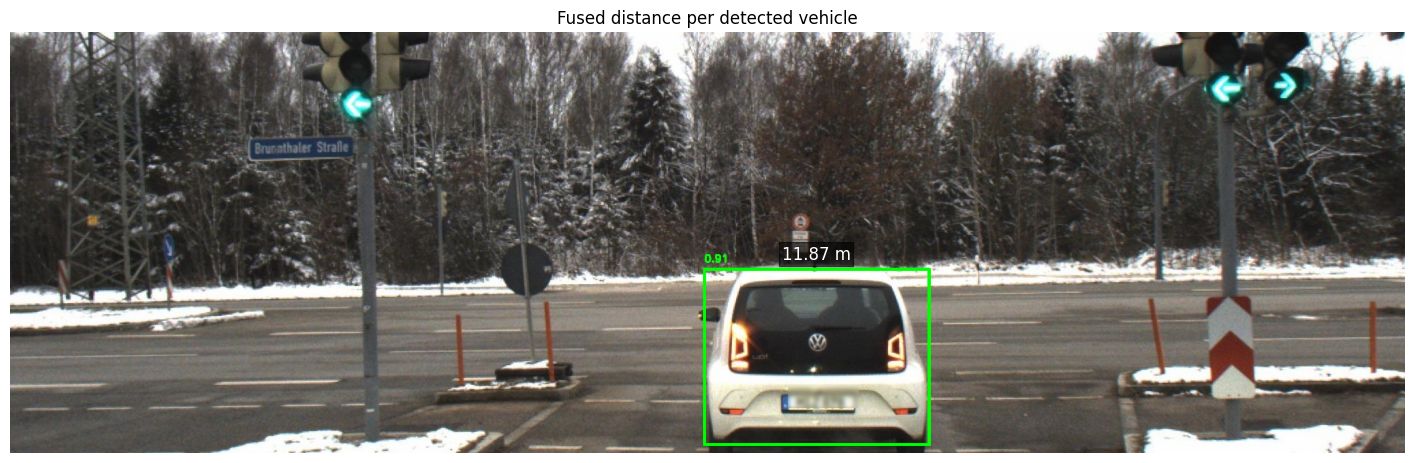

LiDAR mean distances: [10.245140815692334]
Radar  mean distances: [15.670901844266183]
Fused  mean distances: [11.872869124264488]


In [10]:
%matplotlib inline
import json, cv2, numpy as np, matplotlib.pyplot as plt

class calib_astyx():
    def __init__(self, file):
        with open(file) as f:
            d = json.load(f)
        self.radar2ref     = np.array(d["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref_cos = np.array(d["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref    = np.array(d["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K             = np.array(d["sensors"][2]["calib_data"]["K"])
        self.ref2radar  = self.inv_trans(self.radar2ref)
        self.ref2lidar  = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)

    @staticmethod
    def inv_trans(T):
        R = np.linalg.inv(T[:3,:3]); t = -R @ T[:3,3]
        return np.hstack([R, t.reshape(3,1)])

    def lidar2ref(self, pts):
        n = pts.shape[0]
        hom = np.hstack([pts, np.ones((n,1))])
        out = hom @ self.lidar2ref_cos.T
        return out[:,:3]

    def ref2Camera(self, pts, img_size, bbox_list):
        obj_list, mask_list = [], []
        XYZ = (self.ref2camera[:3,:3] @ pts.T) + self.ref2camera[:3,3:4]
        uvw = self.K @ XYZ
        uv  = (uvw / uvw[2])[:2]
        W, H = img_size
        for (x1,y1,x2,y2) in bbox_list:
            m = (uv[0]>=0)&(uv[0]<W)&(uv[1]>=0)&(uv[1]<H)&(uv[0]>=x1)&(uv[0]<=x2)&(uv[1]>=y1)&(uv[1]<=y2)
            obj_list.append(uv[:, m]); mask_list.append(m)
        return obj_list, mask_list

    def mean_distance(self, pts):
        if pts.size == 0: return np.nan
        cam = (self.ref2camera[:3,:3] @ pts) + self.ref2camera[:3,3:4]
        return float(np.mean(np.linalg.norm(cam, axis=0)))

def fused_distance(ld, rd, w_l=0.7, w_r=0.3):
    if np.isnan(ld) and np.isnan(rd): return np.nan
    if np.isnan(ld): return rd
    if np.isnan(rd): return ld
    return w_l*ld + w_r*rd

root = r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019"
i = 85
img   = cv2.imread(f"{root}/vehicle_coordinates/{i:06d}_vehicle_detection.jpg")
lidar = np.loadtxt(f"{root}/lidar_vlp16/{i:06d}.txt",  skiprows=1)
radar = np.loadtxt(f"{root}/radar_6455/{i:06d}.txt",   skiprows=2)
calib = calib_astyx(f"{root}/calibration/{i:06d}.json")

bboxes = [tuple(map(int, line.split())) for line in open(f"{root}/vehicle_coordinates/{i:06d}_vehicle_coordinates.txt")]

lidar[:, :3] = calib.lidar2ref(lidar[:, :3])
lidar_uv, lidar_mask = calib.ref2Camera(lidar[:, :3], (img.shape[1], img.shape[0]), bboxes)
radar_uv, radar_mask = calib.ref2Camera(radar[:, :3], (img.shape[1], img.shape[0]), bboxes)

lidar_mean = [calib.mean_distance(lidar[m,:3].T) for m in lidar_mask]
radar_mean = [calib.mean_distance(radar[m,:3].T) for m in radar_mask]
fused_mean = [fused_distance(ld, rd) for ld, rd in zip(lidar_mean, radar_mean)]

plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
for (x1,y1,x2,y2), fd in zip(bboxes, fused_mean):
    plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor='lime'))
    cx, cy = (x1+x2)//2, max(y1-8, 15)
    txt = "nan" if np.isnan(fd) else f"{fd:.2f} m"
    plt.text(cx, cy, txt, ha="center", va="bottom", color="white",
             fontsize=12, bbox=dict(facecolor="black", alpha=0.6, pad=2))
plt.axis("off"); plt.title("Fused distance per detected vehicle"); plt.show()

print("LiDAR mean distances:", lidar_mean)
print("Radar  mean distances:", radar_mean)
print("Fused  mean distances:", fused_mean)


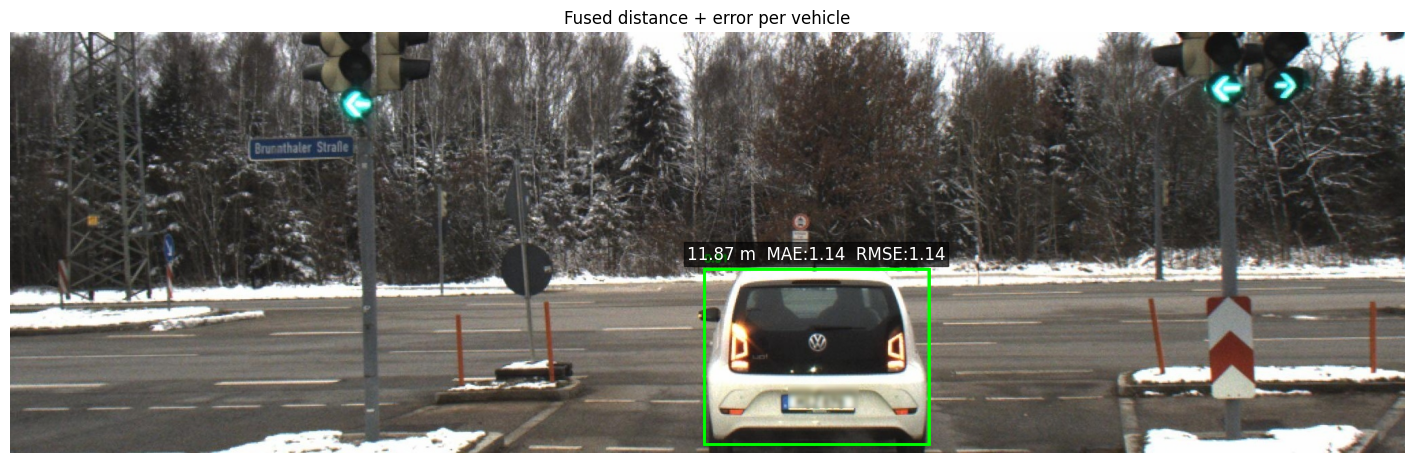

LiDAR: [10.245140815692334]
Radar: [15.670901844266183]
Fused: [11.872869124264488]
MAE: [1.135979389167856]
RMSE: [np.float64(1.135979389167856)]


In [11]:
%matplotlib inline
import json, cv2, numpy as np, matplotlib.pyplot as plt

class calib_astyx:
    def __init__(self, file):
        d = json.load(open(file))
        self.radar2ref     = np.array(d["sensors"][0]["calib_data"]["T_to_ref_COS"])
        self.lidar2ref_cos = np.array(d["sensors"][1]["calib_data"]["T_to_ref_COS"])
        self.camera2ref    = np.array(d["sensors"][2]["calib_data"]["T_to_ref_COS"])
        self.K             = np.array(d["sensors"][2]["calib_data"]["K"])
        self.ref2radar  = self.inv_trans(self.radar2ref)
        self.ref2lidar  = self.inv_trans(self.lidar2ref_cos)
        self.ref2camera = self.inv_trans(self.camera2ref)
    @staticmethod
    def inv_trans(T):
        R = np.linalg.inv(T[:3,:3]); t = -R @ T[:3,3]
        return np.hstack([R, t.reshape(3,1)])
    def lidar2ref(self, pts):
        n = pts.shape[0]; hom = np.hstack([pts, np.ones((n,1))])
        return (hom @ self.lidar2ref_cos.T)[:,:3]
    def ref2Camera(self, pts, img_size, bbox_list):
        XYZ = (self.ref2camera[:3,:3] @ pts.T) + self.ref2camera[:3,3:4]
        uvw = self.K @ XYZ; uv = (uvw/uvw[2])[:2]
        W, H = img_size; objs, masks = [], []
        for x1,y1,x2,y2 in bbox_list:
            m = (uv[0]>=0)&(uv[0]<W)&(uv[1]>=0)&(uv[1]<H)&(uv[0]>=x1)&(uv[0]<=x2)&(uv[1]>=y1)&(uv[1]<=y2)
            objs.append(uv[:, m]); masks.append(m)
        return objs, masks
    def mean_distance(self, pts):
        if pts.size == 0: return np.nan
        cam = (self.ref2camera[:3,:3] @ pts) + self.ref2camera[:3,3:4]
        return float(np.mean(np.linalg.norm(cam, axis=0)))

def fuse(ld, rd, wl=0.7, wr=0.3):
    if np.isnan(ld) and np.isnan(rd): return np.nan
    if np.isnan(ld): return rd
    if np.isnan(rd): return ld
    return wl*ld + wr*rd

root = r"D:\sftask1data\Astyx_dataset\dataset_astyx_hires2019\dataset_astyx_hires2019"
i = 85
img   = cv2.imread(f"{root}/vehicle_coordinates/{i:06d}_vehicle_detection.jpg")
lidar = np.loadtxt(f"{root}/lidar_vlp16/{i:06d}.txt",  skiprows=1)
radar = np.loadtxt(f"{root}/radar_6455/{i:06d}.txt",   skiprows=2)
calib = calib_astyx(f"{root}/calibration/{i:06d}.json")

bboxes = [tuple(map(int, line.split())) for line in open(f"{root}/vehicle_coordinates/{i:06d}_vehicle_coordinates.txt")]

lidar[:, :3] = calib.lidar2ref(lidar[:, :3])
lidar_uv, lidar_m = calib.ref2Camera(lidar[:, :3], (img.shape[1], img.shape[0]), bboxes)
radar_uv, radar_m = calib.ref2Camera(radar[:, :3], (img.shape[1], img.shape[0]), bboxes)

lidar_mean = [calib.mean_distance(lidar[m, :3].T) for m in lidar_m]
radar_mean = [calib.mean_distance(radar[m, :3].T) for m in radar_m]
fused = [fuse(ld, rd) for ld, rd in zip(lidar_mean, radar_mean)]

gt = json.load(open(f"{root}/groundtruth_obj3d/{i:06d}.json"))
true = [float(np.linalg.norm(np.array(o["center3d"]))) for o in gt["objects"]][:len(bboxes)]

mae, rmse = [], []
for fd, td in zip(fused, true):
    if np.isnan(fd): mae.append(np.nan); rmse.append(np.nan)
    else:
        e = fd - td
        mae.append(abs(e)); rmse.append(np.sqrt(e*e))

plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax = plt.gca()
for (x1,y1,x2,y2), fd, m, r in zip(bboxes, fused, mae, rmse):
    ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor='lime'))
    cx, cy = (x1+x2)//2, max(y1-8, 15)
    t1 = "nan" if np.isnan(fd) else f"{fd:.2f} m"
    t2 = ""   if np.isnan(m)  else f"  MAE:{m:.2f}  RMSE:{r:.2f}"
    plt.text(cx, cy, t1+t2, ha="center", va="bottom", color="white", fontsize=12,
             bbox=dict(facecolor="black", alpha=0.6, pad=2))
plt.axis("off"); plt.title("Fused distance + error per vehicle"); plt.show()

print("LiDAR:", lidar_mean)
print("Radar:", radar_mean)
print("Fused:", fused)
print("MAE:", mae)
print("RMSE:", rmse)
